In [1]:
from dataclasses import dataclass
from typing import  Any
from enum import Enum

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import warnings

In [2]:
class Color(Enum):
    RED = True
    BLACK = False

In [3]:
@dataclass
class Node:
    key: Any
    val: Any
    color: Color
    parent: object
    left: object
    right: object

    def __str__(self) -> str:
        return f'\t\tKey: {self.key}; Color: {self.color}; Parent:{self.parent.key if self.parent is not None else self.parent}\n Left:{self.left.key}\t\t\t Right:{self.right.key}'

    def grand_parent(self):
        if self.parent is not None:
            return self.parent.parent
        else:
            return None

    def uncle(self):
        gp = self.grand_parent()
        if gp is None:
            return None
        if self.parent is gp.left:
            return gp.right
        else:
            return gp.left
        
    def sibling(self):
        if self.parent is None:
            return None
        if self is self.parent.left:
            return self.parent.right
        else:
            return self.parent.left

In [113]:
class rb_tree:
    root: object

    # Temporary constructor
    def __init__(self, root=None) -> None:
        self.root = root

    # def rotate_left(self, node):
    #     # We are given the parent of the new node
    #     gp = node.parent
    #     # We change the  child of grand parent to the new node
    #     if node is gp.left:
    #         gp.left = node.right
    #         gp.left.parent = gp
    #     else:
    #         gp.right = node.right
    #         gp.right.parent = gp
    #
    #     # We will change the value of the right child of the parent to the left child of the new node
    #     temp_right_node = node.right
    #     node.right = node.right.left
    #     node.right.parent = node
    #
    #     temp_right_node.left = node
    #     node.parent = temp_right_node

    def rotate_left(self, node):
        R_child = node.right
        node.right = R_child.left
        if R_child.left is not None :
            R_child.left.parent = node
        R_child.parent = node.parent
        if node.parent is None :
            self.root = R_child
        elif node is node.parent.left :
            node.parent.left = R_child
        else :
            node.parent.right = R_child
        R_child.left = node
        node.parent = R_child

    def rotate_right(self, node):
        L_child = node.left
        node.left = L_child.right
        if L_child.right is not None :
            L_child.right.parent = node
        L_child.parent = node.parent
        if node.parent is None :
            self.root = L_child
        elif node is node.parent.right :
            node.parent.right = L_child
        else :
            node.parent.left = L_child
        L_child.right = node
        node.parent = L_child

    def insert(self, key, val):
        # Create a red node with two black leaves
        node = Node(key, val, Color.RED, None, None, None)
        node.left = Node(None, None, Color.BLACK, node, None, None)
        node.right = Node(None, None, Color.BLACK, node, None, None)
        # Insert the node at a leaf position
        if self.root is None:
            position_node = node
            self.root = position_node
        else:
            position_node = self.search_tree(self.root, key)
            # Since we don't know if the node we got is the left or right child, we compare
            if position_node.key == node.key:
                position_node.value = val
                warning_message = "Duplicate Key: {key} found. Value updated".format(key=node.key)
                warnings.warn(warning_message, category=SyntaxWarning)
                return
            elif position_node.parent.left is position_node:
                position_node.parent.left = node
            else:
                position_node.parent.right = node
            node.parent = position_node.parent
        # Case 1
        if node.parent is None :
            node.color = Color.BLACK
            return

        # Case 2
        if node.grand_parent() is None :
            return

        # Balancing the tree after insert operation
        self.fix(node)
        

    # Reccursive function to insert a node like a binary search tree
    def search_tree(self, node, search_key) -> Node:
        # Since in rb trees we also insert None nodes after each node, we need to
        # check if key of the node is none or if a duplicate key is present
        if node.key is None or node.key == search_key:
            return node

        if node.key < search_key:
            return self.search_tree(node.right, search_key)
        

        return self.search_tree(node.left, search_key)

    def fix(self, node):
        # Case 2 condition
        while node.parent.color == Color.RED:
            if node.parent is node.grand_parent().right:
                uncle = node.uncle()
                # Case 3
                if uncle.color == Color.RED:
                    uncle.color = Color.BLACK
                    node.parent.color = Color.BLACK
                    node.grand_parent().color = Color.RED
                    node = node.grand_parent()
                else:
                    # Case 4 pt 2
                    if node is node.parent.left:
                        node = node.parent
                        self.rotate_right(node)
                    # Case 5 pt 2
                    else:
                        node.parent.color = Color.BLACK
                        node.grand_parent().color = Color.RED
                        self.rotate_left(node.grand_parent())
            else:
                uncle = node.uncle()
                # Case 3
                if uncle.color == Color.RED:
                    uncle.color = Color.BLACK
                    node.parent.color = Color.BLACK
                    node.grand_parent().color = Color.RED
                    node = node.grand_parent()
                else:
                    # Case 4 pt 1
                    if node is node.parent.right:
                        node = node.parent
                        self.rotate_left(node)
                    # Case 5 pt 1
                    else:
                        node.parent.color = Color.BLACK
                        node.grand_parent().color = Color.RED
                        self.rotate_right(node.grand_parent())
            if node == self.root:
                break
        self.root.color = Color.BLACK
                    

    def replace_node(self,node, child):
        # Replace nodes in the child;s position
        if child.left is not None and child.left.key is not None:
            if child is child.parent.left:
                child.parent.left = child.left
            else:
                child.parent.right = child.left
            child.left.parent = child.parent

        elif child.right.key is not None and child.right.key is not None:
            if child is child.parent.left:
                child.parent.left = child.right
            else:
                child.parent.right = child.right
            child.right.parent = child.parent
        else:
            if child is child.parent.left:
                child.parent.left = child.left
            elif child is child.parent.right:
                child.parent.right = child.left
            del child.right
        # Replace nodes in the parent's position
        child.parent = node.parent
        child.left = node.left
        child.left.parent = child
        child.right = node.right
        child.right.parent = child
        
        if node.parent is not None:
            if node is node.parent.left:
                node.parent.left = child
            else:
                node.parent.right = child
        else:
            self.root = child
        del node


    def delete_child(self, n):
        # Deleting leaf node
        if n.right.key is None and n.left.key is None:
            if n.parent is None:
                self.root = None
                del n.left
            elif n is n.parent.right:
                n.parent.right = n.left
            else:
                n.parent.left = n.left
            del n.right
        else:
            if n.right.key is None:
                child = n.left
            elif n.left.key is None:
                child = n.right
            else:
                child = n.left
                while(child.right.key is not None):
                    child = child.right
        
        self.replace_node(n,child)
        # if(n.color == Color.BLACK):
        #     if(child.color == Color.RED):
        #         child.color = Color.BLACK
        #     else:
        #         del_case1(child)
            
        

    def delete(self, key):
        node = self.search_tree(self.root, key)
        if node.key is None:
            raise KeyError('Invalid Key')
        else:
            self.delete_child(node)
            





In [114]:
# A valid Red-Black Tree
# Children of right node

# Node(key, val, color, parent, left, right)
right_l = Node(3, None, Color.RED, None, None, None)
right_l.left = Node(None, None, Color.BLACK, right_l, None, None)
right_l.right = Node(None, None, Color.BLACK, right_l, None, None)

right_r = Node(5, None, Color.RED, None, None, None)
right_r.left = Node(None, None, Color.BLACK, right_r, None, None)
right_r.right = Node(None, None, Color.BLACK, right_r, None, None)
# Root Node
root = Node(2, None, Color.BLACK, None, None, None)

right = Node(4, None, Color.BLACK, root, right_l, right_r)
left = Node(1, None, Color.BLACK, root, None, None)
# Children of root
root.left = left
root.right = right

right_r.parent = right
right_l.parent = right

left.left= Node(None, None, Color.BLACK, left, None, None)
left.right = Node(None, None, Color.BLACK, left, None, None)

# Pre constructed tree example
rb = rb_tree(root)



In [115]:
def create_graph(node,g,colors):
  if(node.left.key != None):
    g.add_edge(node.key,node.left.key)
    colors.append(str(node.left.color)[6:])
    create_graph(node.left,g,colors)
  if(node.right.key != None):
    g.add_edge(node.key,node.right.key)
    colors.append(str(node.right.color)[6:])
    create_graph(node.right,g,colors)

In [116]:
def display_graph(root):
  g = nx.Graph()
  colors = []
  colors.append(str(root.color)[6:])
  create_graph(root,g,colors)
  pos = graphviz_layout(g, prog="dot")
  nx.draw(g, pos,with_labels=True, node_color=colors, font_color="white")
  plt.show()

In [117]:
# display_graph(rb.root)

C:\Users\ogbon\AppData\Local\Temp\ipykernel_29020\983946498.py:72: SyntaxWarning: Duplicate Key: 5 found. Value updated
  warnings.warn(warning_message, category=SyntaxWarning)


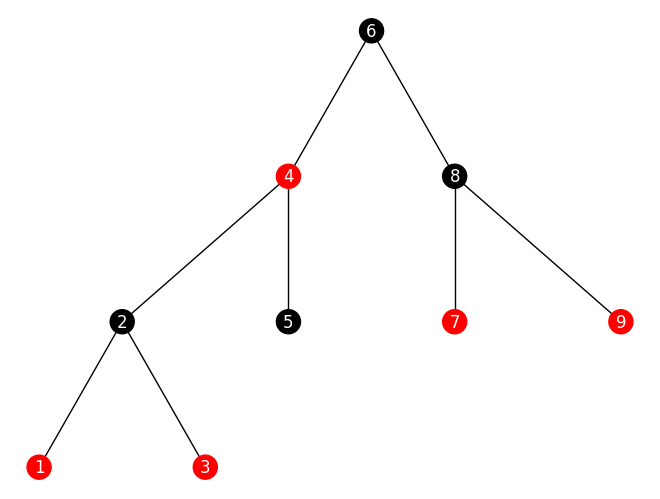

In [118]:
rb = rb_tree()
for i in range(5,10):
    rb.insert(i,1)
    # display_graph(rb.root)
for i in range(5,0, -1):
    rb.insert(i,1)
    # display_graph(rb.root)
display_graph(rb.root)

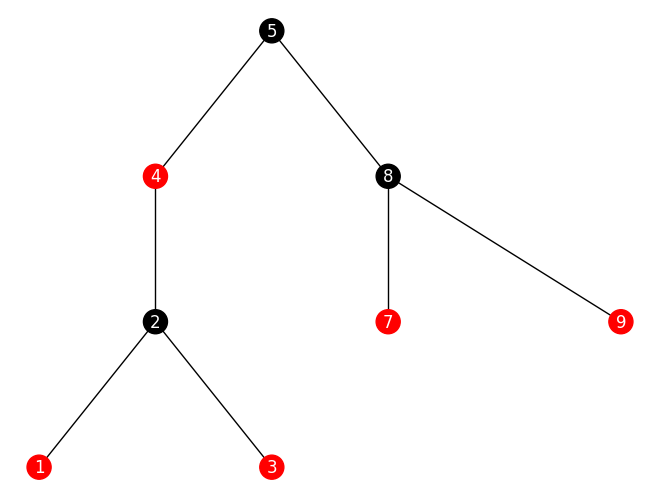

In [119]:
rb.delete(6)
display_graph(rb.root)